In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score as auc
from sklearn.metrics import classification_report as report
from sklearn.preprocessing import StandardScaler
import pickle


### Models 4 (3 & 4 ARE PREDSIZE 1), Forecast Run 1

In [4]:
#tfidf features
#tfidf_words = ['left', 'hospital', 'right', 'small', 'blood', 'patient', 'daily', 'assessment', 'clear', 'noted', 'action', 'pulmonary', 'response', 'plan', 'pain', 'stable', 'hct', 'fluid', 'meq', 'urine', 'continue', 'chest', 'clip', 'number', 'radiology', 'reason', 'medical', 'year', 'old', 'examination', 'final', 'report', 'day', 'status', 'present', 'normal', 'tube', 'acute', 'respiratory', 'failure', 'care', 'history', 'icu', 'tablet', 'lung', 'given', 'seen', 'line', 'contrast', 'valve']
#tfidf_words
"""
chest 	0.033754
care 	0.032076
urine 	0.030525
day 	0.030009
final 	0.029927
lung 	0.028957
seen 	0.028083
patient 0.027310
report 	0.027091
year 	0.026016
daily 	0.025909
hct 	0.024847
tablet 	0.024462
blood 	0.023880
respiratory 	0.023798
examination 	0.023738
right 	0.023121
icu 	0.022048
valve 	0.021717
radiology 	0.020575
line 	0.020083
medical 	0.019867
meq 	0.019810
clear 	0.019440
status 	0.019176
plan 	0.019171
response 	0.019155
acute 	0.018978
clip 	0.018692
present 	0.018413
stable 	0.018383
hospital 	0.018349
history 	0.018278
number 	0.017874
tube 	0.017609
small 	0.017253
old 	0.017168
normal 	0.017150
fluid 	0.016643
pulmonary 	0.016506
pain 	0.015255
assessment 	0.015216
failure 	0.014833
noted 	0.011953
left 	0.011104
continue 	0.009939
contrast 	0.008908
reason 	0.008502
action 	0.006570
given 	0.001878
"""

'\nchest \t0.033754\ncare \t0.032076\nurine \t0.030525\nday \t0.030009\nfinal \t0.029927\nlung \t0.028957\nseen \t0.028083\npatient 0.027310\nreport \t0.027091\nyear \t0.026016\ndaily \t0.025909\nhct \t0.024847\ntablet \t0.024462\nblood \t0.023880\nrespiratory \t0.023798\nexamination \t0.023738\nright \t0.023121\nicu \t0.022048\nvalve \t0.021717\nradiology \t0.020575\nline \t0.020083\nmedical \t0.019867\nmeq \t0.019810\nclear \t0.019440\nstatus \t0.019176\nplan \t0.019171\nresponse \t0.019155\nacute \t0.018978\nclip \t0.018692\npresent \t0.018413\nstable \t0.018383\nhospital \t0.018349\nhistory \t0.018278\nnumber \t0.017874\ntube \t0.017609\nsmall \t0.017253\nold \t0.017168\nnormal \t0.017150\nfluid \t0.016643\npulmonary \t0.016506\npain \t0.015255\nassessment \t0.015216\nfailure \t0.014833\nnoted \t0.011953\nleft \t0.011104\ncontinue \t0.009939\ncontrast \t0.008908\nreason \t0.008502\naction \t0.006570\ngiven \t0.001878\n'

## Load Data, read comments to generate / load from disk

In [2]:
#lab data, extracted from mimic, preprocessed
#forecasts from strats model, trained on train data, and then tasked to forecast test patients that it did never encounter during training. It got 4 hours of input and forecast 12 next hours.
print("loading STraTS-notext data and forecast and STraTS-SB IDs to get reference IDs that are in notext and text")
no_text_forecasts = pd.read_pickle("Experiments/unseeded_models/forecasts/pred_size1_STraTS_20-124V2_4-28_forecast.pkl")
notext_forecasts = no_text_forecasts[0]
notext_var_map = list(no_text_forecasts[1].keys())
test_IDs = list(notext_forecasts["ts_ind"])
del no_text_forecasts

s_b_forecasts = pd.read_pickle("Experiments/unseeded_models/forecasts/pred_size1_SB_STraTS_20-124V2_4-28_forecast.pkl")
sb_forecasts = s_b_forecasts[0]
sb_var_map = list(s_b_forecasts[1].keys())
sb_test_IDs = list(sb_forecasts["ts_ind"])

del s_b_forecasts

full_ids = set(test_IDs) & set(sb_test_IDs)

print("loading STraTS-notext data and forecast")
with open("./data/mimic_notext.pkl", "rb") as pfile:
    raw_data = pickle.load(pfile)

## run following rows once 
## then comment out to generate data in correct format for evaluation, takes long
#notext_mimic = raw_data[0]
#notext_mimic = notext_mimic.loc[notext_mimic["ts_ind"].isin(test_IDs)]
#notext = notext_mimic.pivot_table(index=['ts_ind', "hour"], columns='variable', values='value')
#notext = notext.reset_index()
#print(notext)
#notext.to_pickle("mimic_notext_for_eval.pkl")

#uncomment following line if you have generated the data already
notext = pd.read_pickle("./data/mimic_notext_for_eval.pkl")

#notext_meta = raw_data[1]
#notext_oc = notext_meta

del raw_data


## Sentence Bert
print("loading Sentence Bert STraTS data and forecast.")

#s_b_forecasts = pd.read_pickle("Experiments/unseeded_models/forecasts/SB_STraTS_20-124V2_4-28-2_forecast.pkl")
#sb_forecasts = s_b_forecasts[0]
#sb_var_map = list(s_b_forecasts[1].keys())
#sb_test_IDs = list(sb_forecasts["ts_ind"])

#del s_b_forecasts
with open("./data/mimic_and_sbert_for_thesis.pkl", "rb") as pfile:
    sb_raw_data = pickle.load(pfile)


## run following rows once 
# then comment out to generate data in correct format for evaluation, takes long
#sb_mimic = sb_raw_data[0]
#sb_mimic = sb_mimic.loc[sb_mimic["ts_ind"].isin(sb_test_IDs)]
#print(len(sb_mimic))
#sb = sb_mimic.pivot_table(index=['ts_ind', "hour"], columns='variable', values='value')
#sb = sb.reset_index()
#sb.to_pickle("mimic_and_sbert_for_eval.pkl")

#uncomment following line if you have generated the data already
sb = pd.read_pickle("./data/mimic_and_sbert_for_eval.pkl")

#sb_meta = sb_raw_data[1]
#sb_oc = sb_meta

del sb_raw_data

# TF-IDF
print("loading TF-IDF STraTS data and forecast.")
t_f_forecasts = pd.read_pickle("Experiments/unseeded_models/forecasts/pred_size1_TF_STraTS_20-124V2_4-28_forecast.pkl")
tf_forecasts = t_f_forecasts[0]
tf_var_map = list(t_f_forecasts[1].keys())
tf_test_IDs = list(tf_forecasts["ts_ind"])
del t_f_forecasts

with open("./data/mimic_and_tfidf_for_thesis.pkl", "rb") as pfile:
    tf_raw_data = pickle.load(pfile)


## run following rows once 
# then comment out to generate data in correct format for evaluation, takes long
#tf_mimic = tf_raw_data[0]
#tf_mimic = tf_mimic.loc[tf_mimic["ts_ind"].isin(tf_test_IDs)]
#tf = tf_mimic.pivot_table(index=['ts_ind', "hour"], columns='variable', values='value')
#tf = tf.reset_index()
#tf.to_pickle("mimic_and_tfidf_for_eval.pkl")

#tf_meta = tf_raw_data[1]
#tf_oc = tf_meta

del tf_raw_data

#uncomment following line if you have generated the data already
tf = pd.read_pickle("./data/mimic_and_tfidf_for_eval.pkl")

del test_IDs, sb_test_IDs, tf_test_IDs

loading STraTS-notext data and forecast and STraTS-SB IDs to get reference IDs that are in notext and text
loading STraTS-notext data and forecast
loading Sentence Bert STraTS data and forecast.
loading TF-IDF STraTS data and forecast.


In [3]:
def build_obs(df, mapping):
    # Convert 'hour' to timedelta for proper grouping
    df["hour"] = df["hour"].sub(4)
    df['hour'] = pd.to_timedelta(df['hour'], unit='h')    
    # Group by time step and calculate the mean for each hour
    grouped = df.groupby(["ts_ind", pd.Grouper(key='hour', freq='1h')])[mapping].mean().reset_index()
    grouped["hour"] = grouped['hour'].dt.floor('H')
    grouped["hour"] = grouped.hour.astype(str).str.replace('0 days ', '')    
    # Create a complete set of expected hours
    expected_hours = pd.date_range(start='00:00:00', end='23:00:00', freq='1H').strftime('%H:%M:%S')

    # Create a DataFrame with all combinations of ts_ind and expected hours
    all_combinations = pd.DataFrame([(i, h) for i in grouped['ts_ind'].unique() for h in expected_hours], columns=['ts_ind', 'hour'])
    # Merge the calculated means with the DataFrame of all combinations
    grouped_filled = pd.merge(all_combinations, grouped, on=['ts_ind', 'hour'], how='left')

    return grouped_filled

def restore_predictions(predictions, mapping):
    l = []
    leng = len(predictions.iloc[0]) / len(mapping)
    for i in range(len(predictions)):
        arr = np.asarray(predictions.iloc[i]).reshape((int(leng),len(mapping)))
        l.append(arr)
    df = pd.concat([pd.DataFrame(arr) for arr in l])#, keys=np.arange(len(l)))
    
    df.columns=mapping
    return df

def mse_loss_with_nans(prediction, target, ax):

    # Mask missing values in target observations
    mask = pd.isna(target)

    # mean of the squared error along axis. 
    # axis 1 is column wise e.g. for each feature
    # axis 0 is row wise e.g. to get mse per timestep
    mse = np.mean((target[~mask]-prediction[~mask])**2, axis=ax)
    #mse = np.sum((target[~mask]-prediction)**2, axis=ax)


    return mse

In [13]:
a = [1,6,3,4,123]
b = [5,1,2,6,3,4]
list(set(a) & set(b))

[1, 3, 4, 6]

In [4]:
#select ids that have data for necessary amount of steps
observed_steps = 4
forecast_steps = 24

print("## NOTEXT")
notext_IDS = list(np.unique(notext["ts_ind"].loc[notext["hour"] >= forecast_steps+observed_steps]))
notext_fo_IDs = notext_forecasts["ts_ind"].loc[notext_forecasts["ts_ind"].isin(notext_IDS)]
notext_fo_IDs = list(set(notext_fo_IDs) & set(full_ids))
#select observed data based on the ids
notext_observe = notext.loc[notext["ts_ind"].isin(notext_fo_IDs)]
#select gold values of the steps that were forecast TODO: THIS NEEDS TO BE EXACTLY 24 STEPS....
notext_observe_targets_ = notext_observe[(notext_observe['hour'] > observed_steps) & (notext_observe['hour'] <= observed_steps+forecast_steps)]
notext_observe_targets = build_obs(notext_observe_targets_, notext_var_map)
#bring forecasts in correct format
notext_fo = restore_predictions(notext_forecasts["forecasting_pred"].loc[notext_forecasts["ts_ind"].isin(notext_IDS)], notext_var_map)
#bring observed in correct format
notext_observe_targets = notext_observe_targets.drop(columns=["ts_ind", "hour"])
notext_fo = notext_fo.reset_index().drop(columns="index")
#compute MSE: for each step, Mean for all variables, of the squared difference between forecast and target
notext_MSE = mse_loss_with_nans(notext_fo, notext_observe_targets,1)
notext_step = list(range(1,25,1)) * len(notext_fo_IDs)
notext_st = pd.DataFrame(notext_step, columns=["step"])
notext_st = notext_st.reset_index().drop(columns="index")
notext_st["mse"] = notext_MSE
notext_st.to_pickle("notext_st.pkl")

del notext_IDS, notext_observe, notext_observe_targets_, notext_MSE, notext_step

print("## SENTENCE BERT")
sb_IDS = list(np.unique(sb["ts_ind"].loc[sb["hour"] >= forecast_steps+observed_steps]))
sb_fo_IDs = sb_forecasts["ts_ind"].loc[sb_forecasts["ts_ind"].isin(sb_IDS)]
sb_fo_IDs = list(set(sb_fo_IDs) & set(notext_fo_IDs))
#select observed data based on the ids
sb_observe = sb.loc[sb["ts_ind"].isin(sb_fo_IDs)]
#select gold values of the steps that were forecast TODO: THIS NEEDS TO BE EXACTLY 24 STEPS....
sb_observe_targets_ = sb_observe[(sb_observe['hour'] > observed_steps) & (sb_observe['hour'] <= observed_steps+forecast_steps)]
sb_observe_targets = build_obs(sb_observe_targets_, sb_var_map)
#bring forecasts in correct format
sb_fo = restore_predictions(sb_forecasts["forecasting_pred"].loc[sb_forecasts["ts_ind"].isin(sb_IDS)], sb_var_map)
#bring observed in correct format
sb_observe_targets = sb_observe_targets.drop(columns=["ts_ind", "hour"])
sb_fo = sb_fo.reset_index().drop(columns="index")
#compute MSE: for each step, Mean for all variables, of the squared difference between forecast and target
sb_MSE = mse_loss_with_nans(sb_fo, sb_observe_targets,1)
sb_step = list(range(1,25,1)) * len(sb_fo_IDs)
sb_st = pd.DataFrame(sb_step, columns=["step"])
sb_st = sb_st.reset_index().drop(columns="index")
sb_st["mse"] = sb_MSE
sb_st.to_pickle("sb_st.pkl")


del sb_IDS, sb_observe, sb_observe_targets_, sb_MSE, sb_step


print("## TF-IDF")
tf_IDS = list(np.unique(tf["ts_ind"].loc[tf["hour"] >= forecast_steps+observed_steps]))
tf_fo_IDs = tf_forecasts["ts_ind"].loc[tf_forecasts["ts_ind"].isin(tf_IDS)]
tf_fo_IDs = list(set(tf_fo_IDs) & set(notext_fo_IDs))
compare = lambda x, y: Counter(x) == Counter(y)
print("This needs to be True True True!", compare(notext_fo_IDs, notext_fo_IDs), compare(notext_fo_IDs, tf_fo_IDs), compare(sb_fo_IDs, tf_fo_IDs))

#select observed data based on the ids
tf_observe = tf.loc[tf["ts_ind"].isin(tf_fo_IDs)]
#select gold values of the steps that were forecast 
tf_observe_targets_ = tf_observe[(tf_observe['hour'] > observed_steps) & (tf_observe['hour'] <= observed_steps+forecast_steps)]
tf_observe_targets = build_obs(tf_observe_targets_, tf_var_map)
#bring forecasts in correct format
tf_fo = restore_predictions(tf_forecasts["forecasting_pred"].loc[tf_forecasts["ts_ind"].isin(tf_IDS)], tf_var_map)
#bring observed in correct format
tf_observe_targets = tf_observe_targets.drop(columns=["ts_ind", "hour"])
tf_fo = tf_fo.reset_index().drop(columns="index")
#compute MSE: for each step, Mean for all variables, of the squared difference between forecast and target
tf_MSE = mse_loss_with_nans(tf_fo, tf_observe_targets,1)
tf_step = list(range(1,25,1)) * len(tf_fo_IDs)
tf_st = pd.DataFrame(tf_step, columns=["step"])
tf_st = tf_st.reset_index().drop(columns="index")
tf_st["mse"] = tf_MSE
tf_st.to_pickle("tf_st.pkl")

del notext_fo_IDs, sb_fo_IDs, tf_IDS, tf_fo_IDs, tf_observe, tf_observe_targets_, tf_MSE, tf_step


## NOTEXT


/var/folders/rm/v29286yx225c2ktvpkpwfr5r0000gq/T/ipykernel_78736/1321755664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour"] = df["hour"].sub(4)
/var/folders/rm/v29286yx225c2ktvpkpwfr5r0000gq/T/ipykernel_78736/1321755664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = pd.to_timedelta(df['hour'], unit='h')


## SENTENCE BERT


/var/folders/rm/v29286yx225c2ktvpkpwfr5r0000gq/T/ipykernel_78736/1321755664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour"] = df["hour"].sub(4)
/var/folders/rm/v29286yx225c2ktvpkpwfr5r0000gq/T/ipykernel_78736/1321755664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = pd.to_timedelta(df['hour'], unit='h')


## TF-IDF
This needs to be True True True! True True True


/var/folders/rm/v29286yx225c2ktvpkpwfr5r0000gq/T/ipykernel_78736/1321755664.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hour"] = df["hour"].sub(4)
/var/folders/rm/v29286yx225c2ktvpkpwfr5r0000gq/T/ipykernel_78736/1321755664.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = pd.to_timedelta(df['hour'], unit='h')


In [5]:
import pickle
pickle.dump([notext_st, notext_fo, notext_observe_targets, notext_var_map], open('idfix_Unseeded5_notext_st_fo_targets_dump.pkl','wb'))
pickle.dump([sb_st, sb_fo, sb_observe_targets, sb_var_map], open('idfix_Unseeded5_sb_st_fo_targets_dump.pkl','wb'))
pickle.dump([tf_st, tf_fo, tf_observe_targets, tf_var_map], open('idfix_Unseeded5_tf_st_fo_targets_dump.pkl','wb'))


In [6]:
#print((len(notext_observe_targets) / 24) - (len(sb_observe_targets) / 24))
#print((len(tf_observe_targets) / 24) - (len(sb_observe_targets) / 24))
#print(sb_observe_targets)

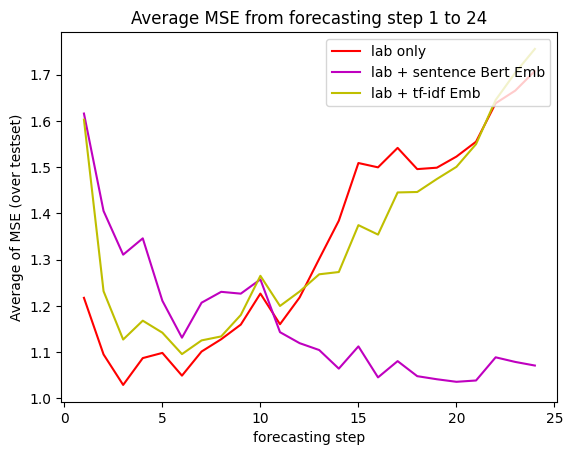

wenn notext hier immer am höchsten ist heißt das, dass sb und tf den forecast von lab unterstützen..
notext lab MSE 1.3828348639417998
sb lab MSE 1.200242078588124
tf lab MSE 1.30308315885231
notext lab MSE 1.3828348639417998
sb lab MSE 1.200242078588124
tf lab MSE 1.30308315885231


In [7]:
## ONLY LAB FEATURES, ALL MODELS, DISREGARD TFID AND BERT, TO SEE HOW THEY HELPED LAB FEATURE FORECASTING
only_lab_notext_fore = notext_fo
only_lab_notext_target = notext_observe_targets
only_lab_sb = sb_fo[notext_fo.columns]
only_lab_sb_target = sb_observe_targets[notext_fo.columns]
only_lab_tf = tf_fo[notext_fo.columns]
only_lab_tf_target = tf_observe_targets[notext_fo.columns]
##sanity id test
#only_lab_notext_fore = notext_fo
#only_lab_notext_target = notext_observe_targets
#only_lab_sb = sb_fo[notext_fo.columns]
only_lab_sb_target = notext_observe_targets
#only_lab_tf = tf_fo[notext_fo.columns]
only_lab_tf_target = notext_observe_targets

tf_step = list(range(1,25,1)) * int((len(only_lab_notext_fore) / 24))
only_notext_st = pd.DataFrame(tf_step, columns=["step"])
only_tf_st = pd.DataFrame(tf_step, columns=["step"])
only_sb_st = pd.DataFrame(tf_step, columns=["step"])

only_notext_st = only_notext_st.reset_index().drop(columns="index")
only_sb_st = only_sb_st.reset_index().drop(columns="index")
only_tf_st = only_tf_st.reset_index().drop(columns="index")

## Stepwise MSE
only_notext_st["mse"] = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, 1)
only_sb_st["mse"] = mse_loss_with_nans(only_lab_sb, only_lab_sb_target, 1)
only_tf_st["mse"] = mse_loss_with_nans(only_lab_tf,only_lab_tf_target, 1)

## Stepwise MSE, Averaged over all patients
only_notext_step_wise_mse_mean = only_notext_st.groupby("step").mean()
only_sb_step_wise_mse_mean = only_sb_st.groupby("step").mean()
only_tf_step_wise_mse_mean = only_tf_st.groupby("step").mean()

fig = plt.figure()
i, color = 0, ['r', 'm', 'y']
for frame in [only_notext_step_wise_mse_mean, only_sb_step_wise_mse_mean, only_tf_step_wise_mse_mean]:
    c = color[i]
    plt.plot(frame.index, frame['mse'], color=c)
    i+=1

#plt.xlim(0,18000)
#plt.ylim(0,30)
plt.title("Average MSE from forecasting step 1 to 24")
plt.xlabel("forecasting step")
plt.ylabel("Average of MSE (over testset)")
plt.legend(['lab only','lab + sentence Bert Emb', 'lab + tf-idf Emb'],loc='upper right')     
plt.show()


print("wenn notext hier immer am höchsten ist heißt das, dass sb und tf den forecast von lab unterstützen..")
print("notext lab MSE",mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, None))
print("sb lab MSE",mse_loss_with_nans(only_lab_sb,only_lab_sb_target, None))
print("tf lab MSE",mse_loss_with_nans(only_lab_tf,only_lab_tf_target, None))


print("notext lab MSE",mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, None))
print("sb lab MSE",mse_loss_with_nans(only_lab_sb,only_lab_notext_target, None))
print("tf lab MSE",mse_loss_with_nans(only_lab_tf,only_lab_notext_target, None))


In [8]:
#print(only_lab_notext_target)
#print(only_lab_sb_target)
print("sanity check ids, sollte empty sein",only_lab_notext_target.compare(only_lab_sb_target))
#print(only_lab_tf_target.compare(only_lab_sb_target))

sanity check ids, sollte empty sein Empty DataFrame
Columns: []
Index: []


Average MSE of Lab Features
wenn notext höher ist perfekt, wenn nicht fraglich wieso
notext    1.438747
sBert      1.26616
tfidf     1.205931
dtype: object


<function matplotlib.pyplot.show(close=None, block=None)>

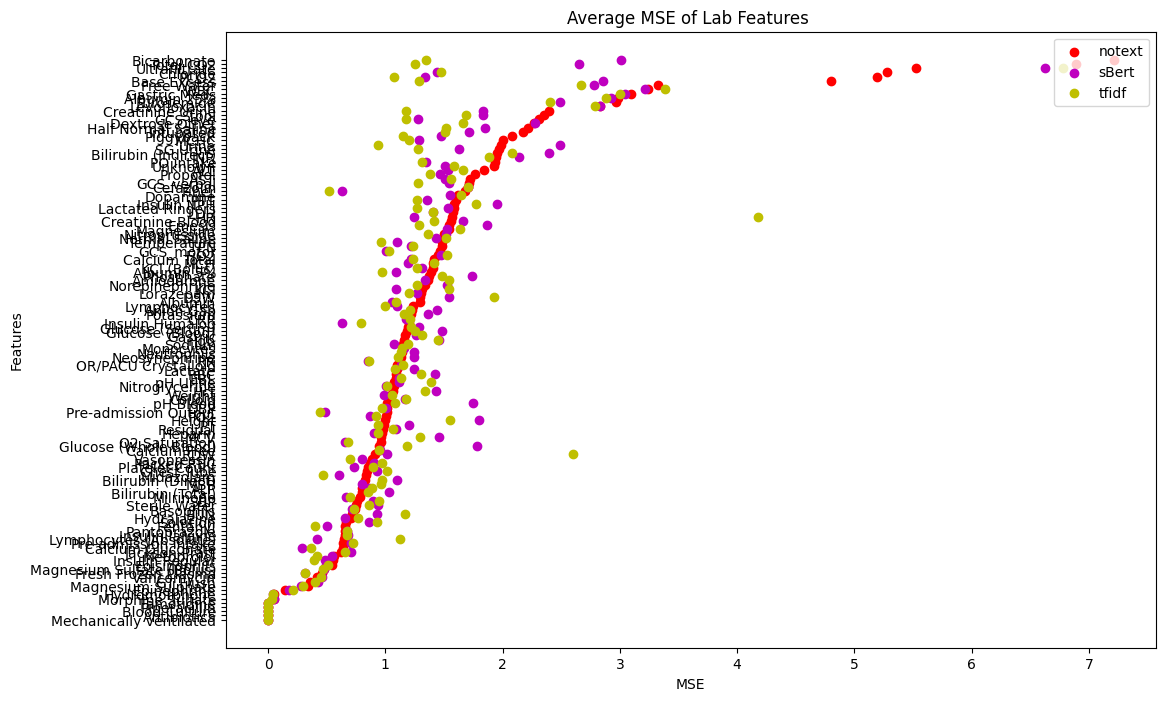

In [9]:
## mse per feature, only laboratory
only_notext_variable_mse = mse_loss_with_nans(only_lab_notext_fore, only_lab_notext_target, 0)
only_sb_variable_mse = mse_loss_with_nans(only_lab_sb,only_lab_sb_target, 0)
only_tf_variable_mse = mse_loss_with_nans(only_lab_tf,only_lab_tf_target, 0)

only_laboratory_only_mse = pd.DataFrame({"notext": only_notext_variable_mse.values, "sBert": only_sb_variable_mse[:len(notext_var_map)].values, "tfidf": only_tf_variable_mse[:len(notext_var_map)].values}, index=notext_var_map)
only_laboratory_only_mse = only_laboratory_only_mse.sort_values(by=["notext"])
print("Average MSE of Lab Features")
print("wenn notext höher ist perfekt, wenn nicht fraglich wieso")
print(only_laboratory_only_mse.mean())
fig = plt.figure(figsize=(12,8))
fig.tight_layout()
i, color = -1, ['r', 'm', 'y']
for frame in [only_laboratory_only_mse["notext"], only_laboratory_only_mse["sBert"], only_laboratory_only_mse["tfidf"]]:
    i+=1
    c = color[i]
    plt.scatter(frame.values, frame.index, color=c)
    #plt.plot(frame.values, frame.index, color=c)
    #plt.plot(([frame.values.mean()]*len(notext_var_map)), frame.index, color=c) 
    
plt.title("Average MSE of Lab Features ")
plt.xlabel("MSE")
plt.ylabel("Features")
plt.legend(['notext','sBert', 'tfidf'],loc='upper right')  
plt.show

## below is deprecated

In [13]:
### MSE on Lab features vs MSE on LAB+SB, vs MSE on lab+TF -> Macht keinen sinn? weil wenn sB oder tf einfacher zu forecasten ists besser
print("STraTS-MSE on Testset, hours 5-28:",mse_loss_with_nans(notext_fo, notext_observe_targets, None))
print("SB-STraTS-MSE on Testset, hours 5-28:",mse_loss_with_nans(sb_fo,sb_observe_targets, None))
print("TF-STraTS-MSE on Testset, hours 5-28:",mse_loss_with_nans(tf_fo,tf_observe_targets, None))

STraTS-MSE on Testset, hours 5-28: 1.307107900848784
SB-STraTS-MSE on Testset, hours 5-28: 0.7621710323573437
TF-STraTS-MSE on Testset, hours 5-28: 0.9292691757127172


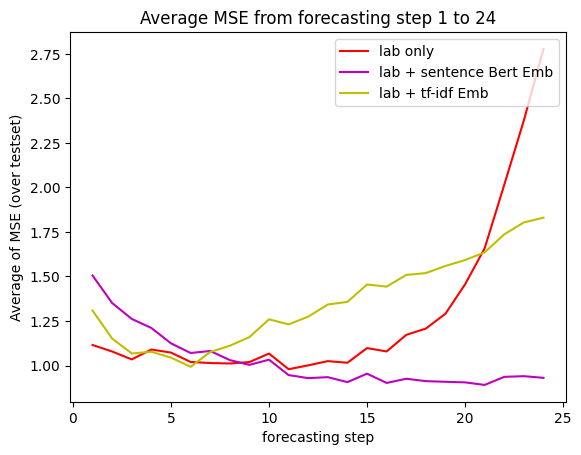

In [14]:
## COMPARE STEP WISE MSE OF LAB ONLY VS LAB+SB VS LAB+TF -> IF SB AND TF EASIER TO FORECAST AUTOMATICALLY LOWER MSE

notext_step_wise_mse_mean = notext_st.groupby("step").mean()
sb_step_wise_mse_mean = sb_st.groupby("step").mean()
tf_step_wise_mse_mean = tf_st.groupby("step").mean()

fig = plt.figure()
i, color = 0, ['r', 'm', 'y']
for frame in [notext_step_wise_mse_mean, sb_step_wise_mse_mean, tf_step_wise_mse_mean]:
    c = color[i]
    plt.plot(frame.index, frame['mse'], color=c)
    i+=1

#plt.xlim(0,18000)
#plt.ylim(0,30)
plt.title("Average MSE from forecasting step 1 to 24")
plt.xlabel("forecasting step")
plt.ylabel("Average of MSE (over testset)")
plt.legend(['lab only','lab + sentence Bert Emb', 'lab + tf-idf Emb'],loc='upper right')     
plt.show()


Still with grain of salt: This is first run of unseeded model, need atleast one more run of forecasts with unseeded model to compare. Then Seeded model, to get reproducible results.

Q: SBert seems to mitigate error accumulation, tf-idf increase it. Why could that be?

Q: Why is tfidf better than sentence Bert? 
Since I am using sentence Bert embeddings and tfidf vectors as INPUT FEATURES, as in, it is treated the same as MeanBP, Temperature etc, and as such also part of the forecast i obtain from strats here are some suspicions. 
Both SentenceBert Embeddings and TFIDF Vectors are representing semantics of text, thus, an accurate forecasting of these features introduces useful information. As far as i understand, the original BERT embeddings were not meant for semantic interpretation, and thus, in theory, it would not work.

Forecasting TF-IDF is essentially forecasting the occurence of important words, so words that play a big role in identifying the target.


--------------------

Fix numpy seed, masking muss rein, Reprpoducability!!!! d.h. ich muss herusfinden wie ich die imputed features remove!!! https://github.com/JINHXu/Early-Sepsis-Prediction-using-TSF/blob/main/data_prep_and_exploration/mimic_preprocessed_data_generation.py vlt ist das unser MIMIC-III mit text! DannText wieder preprocessen? Dann rerun training... sounds simple. MSE benutzen.

Why does stuff work? Sind tfidf und sbert embeddings semantic useful? Does it work? Control Experiments? Adde noise als alternative feature, was passiert? prob keine Zeit. Was könnten alternativen sein.

Für die 40 seiten muss ich ALLES was geht in Formeln bringen, sprich alle losses, PCA, sBert, tfidf, Fourier, feature averages, Model graph bzw bild.

Average MSE of Lab Features
notext    1.599566
sBert     1.260956
tfidf     1.229438
dtype: object


<function matplotlib.pyplot.show(close=None, block=None)>

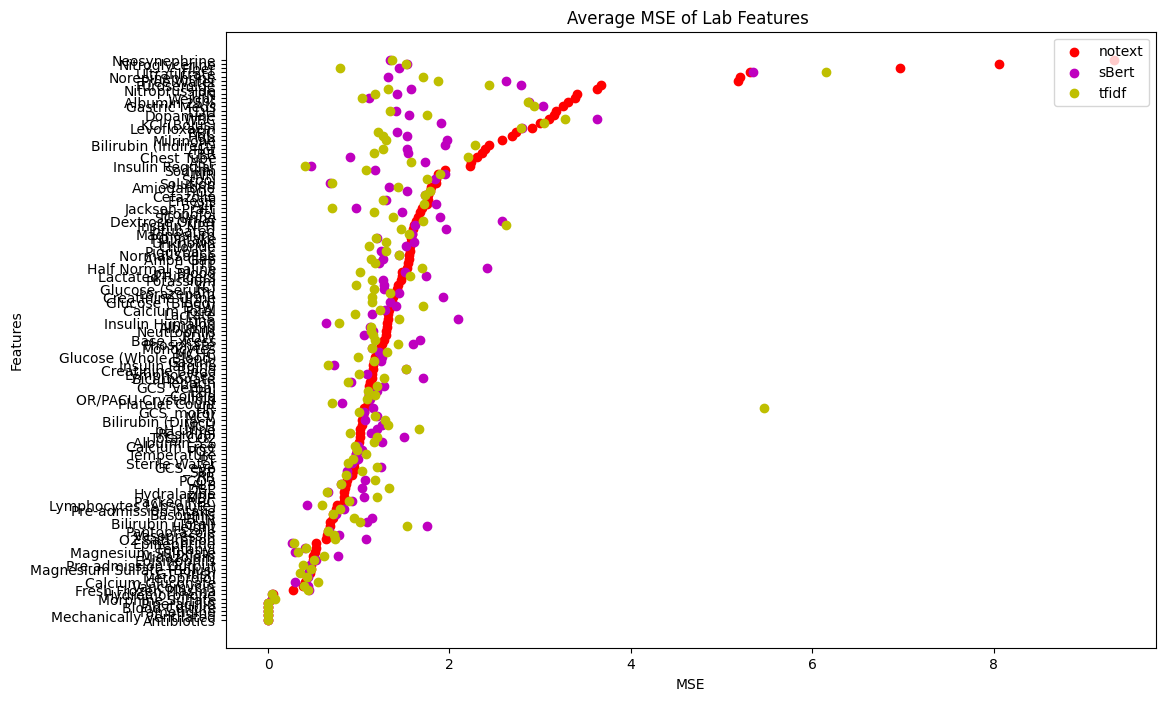

In [15]:

notext_variable_mse = mse_loss_with_nans(notext_fo, notext_observe_targets, 0)
sb_variable_mse = mse_loss_with_nans(sb_fo,sb_observe_targets, 0)
tf_variable_mse = mse_loss_with_nans(tf_fo,tf_observe_targets, 0)

laboratory_only_mse = pd.DataFrame({"notext": notext_variable_mse.values, "sBert": sb_variable_mse[:len(notext_var_map)].values, "tfidf": tf_variable_mse[:len(notext_var_map)].values}, index=notext_var_map)
laboratory_only_mse = laboratory_only_mse.sort_values(by=["notext"])
print("Average MSE of Lab Features")
print(laboratory_only_mse.mean())
fig = plt.figure(figsize=(12,8))
fig.tight_layout()
i, color = -1, ['r', 'm', 'y']
for frame in [laboratory_only_mse["notext"], laboratory_only_mse["sBert"], laboratory_only_mse["tfidf"]]:
    i+=1
    c = color[i]
    plt.scatter(frame.values, frame.index, color=c)
    #plt.plot(frame.values, frame.index, color=c)
    #plt.plot(([frame.values.mean()]*len(notext_var_map)), frame.index, color=c) 
    
plt.title("Average MSE of Lab Features ")
plt.xlabel("MSE")
plt.ylabel("Features")
plt.legend(['notext','sBert', 'tfidf'],loc='upper right')  
plt.show